# Проект "Car price prediction": Извлечение тренировочного датасета

In [1]:
import os
import numpy as np
import pandas as pd
import sys
import time
from bs4 import BeautifulSoup    
import requests 

In [2]:
#Выставим опции pandas для удобства просмотра
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', 200)

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

Парсинг будем делать на локальной машине. Потом используем готовый тренировочный датасет на Kaggle

In [4]:
PATH_to_file = './data/'

Для подготовки к парсингу создадим словарь brand_dict с марками автомобилей и их количесвами в test:

In [8]:
brands = test.brand.value_counts()
brand_dict = {brands.index[i]: brands[i] for i in range(len(brands))}
brand_dict

{'BMW': 4473,
 'VOLKSWAGEN': 4404,
 'NISSAN': 4393,
 'MERCEDES': 4180,
 'TOYOTA': 3913,
 'AUDI': 3421,
 'MITSUBISHI': 2843,
 'SKODA': 2741,
 'VOLVO': 1463,
 'HONDA': 1150,
 'INFINITI': 871,
 'LEXUS': 834}

### Для парсинга сайта авто.ру применим следующий подход:  
- Применим фильтр по г. Москва, берем легковые автомобили с пробегом.  
- Применим фильтр по марке автомобиля из словаря brand_dict, другие марки не берем.  
- Возьмем по 1200 страниц для каждой марки автомобиля. Число страниц установлено опытным путем: как будет показано далее, чем больше номер страницы, тем больше попадается дубликатов объявлений. Дубли мы удалим. 
- Ограничимся основными страницами и не будем заходить на страницы отдельных объявлений.
- Каждую марку парсим в отдельный датасет и записываем в csv. Потом объединяем датасеты в один. Применение этого подхода обусловлено неустойчивостью процесса парсинга (зависание, ошибки 503 "temporary out of service" и т.д.).

Используем простой звуковой индикатор для облегчения контроля за процессом

In [9]:
import jupyter_beeper
beeper = jupyter_beeper.Beeper()

Также используем Progress Bar

In [10]:
%%capture
from tqdm.notebook import tqdm
tqdm().pandas()

Отдельно для каждой марки автомобиля:

In [11]:
brand = 'bmw'

In [12]:
auto_list_global = [] # здесь соберем список списков (эл-т - список параметров конкретного автомобиля)
       
pages_list = list(range(1, 1201)) # количество страниц для парсинга 
with tqdm(total=len(pages_list)) as pbar:
    for i in pages_list: 
            
        url = f'https://auto.ru/moskva/cars/{brand}/used/?output_type=list&page={i}'
        response = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})
        if response.status_code != 200:
            raise BaseException("response code" + str(response.status_code))
        response.encoding = 'utf-8'
        soup = BeautifulSoup(response.text, 'html.parser')
        page = soup.find_all('div', class_='ListingItem-module__container')  

        for k in range(len(page)):     # проход по объявлениям на одной странице
            auto_html = page[k].find_all('meta')
            auto_list = []
            for j in range(len(auto_html)):   # обработка отдельного объявления на странице
                auto_list.append((str(auto_html[j])[15:]).split('"', 1)[0])

            auto_list_short = []
            auto_list_short.append(i) # Добавим пока номер страницы, чтобы узнать, откуда уже идут дубликаты

            # Убираем лишние параметры из списка    
            pos_out = {4,11,12,14,15,19}
            for n in range(len(auto_list)):   # удаление лишних параметров из объявления
                if n not in pos_out:
                    auto_list_short.append(auto_list[n].replace('\xa0', ' ')) 

            # Считываем пробег(расположен в другом месте)    
            all_km = page[k].find('div', class_='ListingItem-module__kmAge')
            km = str(all_km)[39:].split('<', 1)[0].replace('\xa0', ' ')
            auto_list_short.append(str(km))    # добавляем пробег
                
            auto_list_global.append(auto_list_short)    # добавляем список пар-ров автомобиля в список списков

        pbar.update(1)
        if i % 10 == 0:
            beeper.beep(frequency=340, secs=0.3, blocking=True)
        time.sleep(1.2)

In [13]:
len(auto_list_global), len(auto_list_global[0])

(45509, 16)

In [14]:
print(auto_list_global[:2])

[[1, 'седан', 'BMW', 'синий', 'бензин', '2008', 'BMW 3 серии  V (E90/E91/E92/E93) Рестайлинг 325i', '4', '2011', 'SEDAN AUTOMATIC 2.5', 'автоматическая', '735000', '2.5 AT', '2.5 LTR', '218 N12', '260 500 км'], [1, 'внедорожник 5 дв.', 'BMW', 'серый', 'бензин', '2013', 'BMW X5  III (F15) 50i', '5', '2013', 'ALLROAD_5_DOORS AUTOMATIC 4.4', 'автоматическая', '2098000', '4.4 AT', '4.4 LTR', '450 N12', '103 124 км']]


Подберем в первом приближении имена столбцов в соответствии с именами в test. Как будем использовать информацию в столбце temp1, пока не понятно. 

In [15]:
df = pd.DataFrame(auto_list_global,
                  columns=['page', 'bodyType', 'brand', 'color', 'fuelType', 'modelDate', 'model_name',
                           'numberOfDoors', 'productionDate', 'vehicleConfiguration', 'vehicleTransmission',
                           'price', 'temp1', 'engineDisplacement', 'enginePower', 'mileage'])

In [16]:
df.head(3)

,page,bodyType,brand,color,fuelType,modelDate,model_name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,price,temp1,engineDisplacement,enginePower,mileage
0,1,седан,BMW,синий,бензин,2008,BMW 3 серии V (E90/E91/E92/E93) Рестайлинг 325i,4,2011,SEDAN AUTOMATIC 2.5,автоматическая,735000,2.5 AT,2.5 LTR,218 N12,260 500 км
1,1,внедорожник 5 дв.,BMW,серый,бензин,2013,BMW X5 III (F15) 50i,5,2013,ALLROAD_5_DOORS AUTOMATIC 4.4,автоматическая,2098000,4.4 AT,4.4 LTR,450 N12,103 124 км
2,1,седан,BMW,белый,дизель,2011,BMW 3 серии VI (F3x) 320d,4,2012,SEDAN AUTOMATIC 2.0,автоматическая,1350000,2.0 AT,2.0 LTR,184 N12,152 200 км


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45509 entries, 0 to 45508
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   page                  45509 non-null  int64 
 1   bodyType              45509 non-null  object
 2   brand                 45509 non-null  object
 3   color                 45509 non-null  object
 4   fuelType              45509 non-null  object
 5   modelDate             45509 non-null  object
 6   model_name            45509 non-null  object
 7   numberOfDoors         45509 non-null  object
 8   productionDate        45509 non-null  object
 9   vehicleConfiguration  45509 non-null  object
 10  vehicleTransmission   45509 non-null  object
 11  price                 45509 non-null  object
 12  temp1                 45509 non-null  object
 13  engineDisplacement    45509 non-null  object
 14  enginePower           45509 non-null  object
 15  mileage               45509 non-null

Удалим дубли:

In [18]:
df.drop_duplicates(subset=['bodyType', 'brand', 'color', 'fuelType', 'modelDate', 'model_name', 'numberOfDoors',
                           'productionDate', 'vehicleConfiguration', 'vehicleTransmission', 'price', 'temp1',
                           'engineDisplacement', 'enginePower', 'mileage'], inplace=True)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3656 entries, 0 to 44831
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   page                  3656 non-null   int64 
 1   bodyType              3656 non-null   object
 2   brand                 3656 non-null   object
 3   color                 3656 non-null   object
 4   fuelType              3656 non-null   object
 5   modelDate             3656 non-null   object
 6   model_name            3656 non-null   object
 7   numberOfDoors         3656 non-null   object
 8   productionDate        3656 non-null   object
 9   vehicleConfiguration  3656 non-null   object
 10  vehicleTransmission   3656 non-null   object
 11  price                 3656 non-null   object
 12  temp1                 3656 non-null   object
 13  engineDisplacement    3656 non-null   object
 14  enginePower           3656 non-null   object
 15  mileage               3656 non-null  

Запишем данные в csv файл с соответствующим бренду именем:

In [20]:
df.to_csv(PATH_to_file + brand + '.csv', index=False)

Повторив процедуру парсинга для каждой марки автомобиля из словаря, получим 12 файлов; из них потом получим один объединенный датасет train.

Считываем данные из отдельных csv и объединяем

In [5]:
BMW = pd.read_csv(PATH_to_file + 'bmw.csv')
VOLKSWAGEN = pd.read_csv(PATH_to_file + 'volkswagen.csv')
NISSAN = pd.read_csv(PATH_to_file + 'nissan.csv')
MERCEDES = pd.read_csv(PATH_to_file + 'mercedes.csv')
TOYOTA = pd.read_csv(PATH_to_file + 'toyota.csv')
AUDI = pd.read_csv(PATH_to_file + 'audi.csv')
MITSUBISHI = pd.read_csv(PATH_to_file + 'mitsubishi.csv')
SKODA = pd.read_csv(PATH_to_file + 'skoda.csv')
VOLVO = pd.read_csv(PATH_to_file + 'volvo.csv')
HONDA = pd.read_csv(PATH_to_file + 'honda.csv')
INFINITI = pd.read_csv(PATH_to_file + 'infiniti.csv')
LEXUS = pd.read_csv(PATH_to_file + 'lexus.csv')

In [6]:
frames = [BMW, VOLKSWAGEN, NISSAN, MERCEDES, TOYOTA, AUDI, MITSUBISHI, SKODA, VOLVO, HONDA, INFINITI, LEXUS]
train = pd.concat(frames)
train.sample(10)

,page,bodyType,brand,color,fuelType,modelDate,model_name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,price,temp1,engineDisplacement,enginePower,mileage
58,2,хэтчбек 5 дв.,BMW,белый,бензин,2011,BMW 1 серии II (F20/F21) 116i,5.0,2012,HATCHBACK_5_DOORS AUTOMATIC 1.6,автоматическая,670000,1.6 AT,1.6 LTR,136 N12,153 596 км
1716,48,внедорожник 5 дв.,BMW,белый,дизель,2014,BMW X4 I (F26) 30d,5.0,2015,ALLROAD_5_DOORS AUTOMATIC 3.0,автоматическая,2.59e+06,3.0 AT,3.0 LTR,249 N12,79 300 км
327,9,внедорожник 5 дв.,VOLKSWAGEN,синий,дизель,2011,Volkswagen Tiguan I Рестайлинг,5.0,2012,ALLROAD_5_DOORS AUTOMATIC 2.0,автоматическая,995000,2.0 AT,2.0 LTR,140 N12,145 000 км
3670,531,внедорожник 5 дв.,MERCEDES,чёрный,бензин,2005,Mercedes-Benz M-Класс II (W164) 350,5.0,2008,ALLROAD_5_DOORS AUTOMATIC 3.5,автоматическая,770000,3.5 AT,3.5 LTR,272 N12,138 000 км
3079,84,седан,VOLKSWAGEN,коричневый,бензин,2011,Volkswagen Passat B7,4.0,2011,SEDAN ROBOT 1.8,роботизированная,690000,1.8 AMT,1.8 LTR,152 N12,113 000 км
1671,46,внедорожник 5 дв.,TOYOTA,коричневый,дизель,2013,Toyota Land Cruiser Prado 150 Series Рестайлинг 1,5.0,2015,ALLROAD_5_DOORS AUTOMATIC 3.0,автоматическая,2.94e+06,3.0 AT,3.0 LTR,173 N12,62 345 км
94,3,внедорожник 5 дв.,LEXUS,чёрный,бензин,2007,Lexus LX III 570,5.0,2008,ALLROAD_5_DOORS AUTOMATIC 5.7,автоматическая,2.2e+06,5.7 AT,5.7 LTR,367 N12,168 257 км
2529,69,седан,TOYOTA,серебристый,бензин,2006,"Toyota Corolla X (E140, E150) AMT",4.0,2008,SEDAN ROBOT 1.6,роботизированная,420000,1.6 AMT,1.6 LTR,124 N12,93 000 км
166,5,лифтбек,SKODA,серый,бензин,2000,Skoda Octavia I (A4) Рестайлинг,5.0,2002,LIFTBACK MECHANICAL 1.6,механическая,NaN,1.6 MT,1.6 LTR,102 N12,296 000 км
119,4,седан,BMW,чёрный,дизель,2016,BMW 5 серии VII (G30/G31) 520d,4.0,2019,SEDAN AUTOMATIC 2.0,автоматическая,2.35e+06,2.0 AT,2.0 LTR,190 N12,52 000 км


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27064 entries, 0 to 716
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   page                  27064 non-null  int64  
 1   bodyType              27062 non-null  object 
 2   brand                 27064 non-null  object 
 3   color                 27064 non-null  object 
 4   fuelType              27062 non-null  object 
 5   modelDate             27062 non-null  object 
 6   model_name            27064 non-null  object 
 7   numberOfDoors         27062 non-null  float64
 8   productionDate        27064 non-null  object 
 9   vehicleConfiguration  27062 non-null  object 
 10  vehicleTransmission   27062 non-null  object 
 11  price                 26970 non-null  object 
 12  temp1                 27062 non-null  object 
 13  engineDisplacement    27064 non-null  object 
 14  enginePower           27064 non-null  object 
 15  mileage              

Удалим пропуски, так как их мало и большое их количество находится в столбце с целевой переменной price

In [8]:
train.dropna(inplace=True)

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26968 entries, 0 to 715
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   page                  26968 non-null  int64  
 1   bodyType              26968 non-null  object 
 2   brand                 26968 non-null  object 
 3   color                 26968 non-null  object 
 4   fuelType              26968 non-null  object 
 5   modelDate             26968 non-null  object 
 6   model_name            26968 non-null  object 
 7   numberOfDoors         26968 non-null  float64
 8   productionDate        26968 non-null  object 
 9   vehicleConfiguration  26968 non-null  object 
 10  vehicleTransmission   26968 non-null  object 
 11  price                 26968 non-null  object 
 12  temp1                 26968 non-null  object 
 13  engineDisplacement    26968 non-null  object 
 14  enginePower           26968 non-null  object 
 15  mileage              

In [10]:
train[train['price'].str.contains('RUB', na=False)]

,page,bodyType,brand,color,fuelType,modelDate,model_name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,price,temp1,engineDisplacement,enginePower,mileage
624,17,внедорожник 5 дв.,NISSAN,серый,бензин,Nissan X-Trail III,5,2017.0,ALLROAD_5_DOORS VARIATOR 2.0,вариатор,http://schema.org/InStock,RUB,2.0 LTR,144 N12,бензин,69 205 км


In [11]:
indices = train[train.price.str.lower().str.contains('rub', na=False)].index
train.drop(indices, inplace=True)

Преобразуем целевую переменную price в числовой формат

In [12]:
train.price = train.price.astype('int64')

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26957 entries, 0 to 715
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   page                  26957 non-null  int64  
 1   bodyType              26957 non-null  object 
 2   brand                 26957 non-null  object 
 3   color                 26957 non-null  object 
 4   fuelType              26957 non-null  object 
 5   modelDate             26957 non-null  object 
 6   model_name            26957 non-null  object 
 7   numberOfDoors         26957 non-null  float64
 8   productionDate        26957 non-null  object 
 9   vehicleConfiguration  26957 non-null  object 
 10  vehicleTransmission   26957 non-null  object 
 11  price                 26957 non-null  int64  
 12  temp1                 26957 non-null  object 
 13  engineDisplacement    26957 non-null  object 
 14  enginePower           26957 non-null  object 
 15  mileage              

In [14]:
train.sample(3)

,page,bodyType,brand,color,fuelType,modelDate,model_name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,price,temp1,engineDisplacement,enginePower,mileage
440,13,внедорожник 5 дв.,BMW,чёрный,дизель,2010,BMW X5 II (E70) Рестайлинг 40d,5.0,2011,ALLROAD_5_DOORS AUTOMATIC 3.0,автоматическая,1525000,3.0 AT,3.0 LTR,306 N12,175 200 км
918,25,внедорожник 5 дв.,VOLVO,чёрный,бензин,2006,Volvo XC90 I Рестайлинг,5.0,2011,ALLROAD_5_DOORS AUTOMATIC 2.5,автоматическая,1050000,2.5 AT,2.5 LTR,210 N12,145 000 км
1833,50,лифтбек,SKODA,белый,бензин,2015,Skoda Superb III,5.0,2016,LIFTBACK ROBOT 1.4,роботизированная,1235000,1.4 AMT,1.4 LTR,150 N12,122 600 км


Посмотрим на распределение количества объявлений по номерам страниц

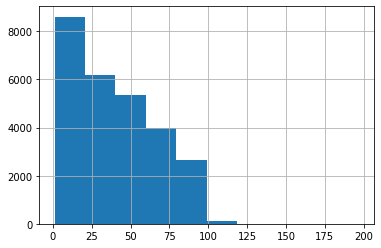

In [15]:
train[train.page < 200].page.hist()

Так как на сайте количество объявлений на странице почти фиксированное (37 - 38 объявлений) и мы удалили дубли, то можем заключить, что есть тренд к увеличению количества дублей с ростом номера страницы.

Запишем данные в итоговый csv файл

In [16]:
train.to_csv(PATH_to_file + 'train.csv', index=False)

### В итоге мы получили тренировочный датасет train.csv с 26957 записей